In [1]:
import torch
import cv2
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
# from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

import os
import torch.nn.functional as F
from torch.utils.data import Dataset

import random
import numpy as np
import json

from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [2]:
class Gopro_Loader(Dataset):
    def __init__(self, data_path, augmentation=False):
        self.data_path = data_path
        self.augmentation = augmentation
        self.imgs = glob.glob(os.path.join(data_path, 'blur/*.png'))

    def __getitem__(self, idx):
        # 讀取影像
        img_path = self.imgs[idx]
        label_path = img_path.replace("blur", "sharp")
        
        # 讀取標籤
        img = Image.open(img_path)
        label = Image.open(label_path)
        
        transform = transforms.Compose([
            transforms.Resize([368, 640]),
            transforms.ToTensor(),
        ])
        
        if self.augmentation:
            # 固定隨機參數
            p1 = random.randint(0,1)
            p2 = random.randint(0,1)

            px = random.uniform(0,1)
            py = random.uniform(0,1)
            crop_size = (368, 640)
            
            def random_crop(img):
                x = (img.size[0]-crop_size[0])*px
                y = (img.size[1]-crop_size[1])*py
                return img.crop((x, y, x+crop_size[0], y+crop_size[1]))

            transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p1),
                transforms.RandomVerticalFlip(p2),
                transforms.Lambda(random_crop),
                transforms.ToTensor(),
            ])

        img = transform(img)
        label = transform(label)
        return img, label

    def __len__(self):
        return len(self.imgs)

## SSIM

In [3]:
def gaussian_filter(input, win):
    r""" Blur input with 1-D kernel
    Args:
        input (torch.Tensor): a batch of tensors to be blurred
        window (torch.Tensor): 1-D gauss kernel
    Returns:
        torch.Tensor: blurred tensors
    """
    assert all([ws == 1 for ws in win.shape[1:-1]]), win.shape
    if len(input.shape) == 4:
        conv = F.conv2d
    elif len(input.shape) == 5:
        conv = F.conv3d
    else:
        raise NotImplementedError(input.shape)

    C = input.shape[1]
    out = input
    for i, s in enumerate(input.shape[2:]):
        if s >= win.shape[-1]:
            out = conv(out, weight=win.transpose(2 + i, -1), stride=1, padding=0, groups=C)
        else:
            warnings.warn(
                f"Skipping Gaussian Smoothing at dimension 2+{i} for input: {input.shape} and win size: {win.shape[-1]}"
            )

    return out

def _ssim(X, Y, data_range, win, size_average=True, K=(0.01, 0.03)):

    r""" Calculate ssim index for X and Y
    Args:
        X (torch.Tensor): images
        Y (torch.Tensor): images
        win (torch.Tensor): 1-D gauss kernel
        data_range (float or int, optional): value range of input images. (usually 1.0 or 255)
        size_average (bool, optional): if size_average=True, ssim of all images will be averaged as a scalar
    Returns:
        torch.Tensor: ssim results.
    """
    K1, K2 = K
    # batch, channel, [depth,] height, width = X.shape
    compensation = 1.0

    C1 = (K1 * data_range) ** 2
    C2 = (K2 * data_range) ** 2

    win = win.to(X.device, dtype=X.dtype)

    mu1 = gaussian_filter(X, win)
    mu2 = gaussian_filter(Y, win)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = compensation * (gaussian_filter(X * X, win) - mu1_sq)
    sigma2_sq = compensation * (gaussian_filter(Y * Y, win) - mu2_sq)
    sigma12 = compensation * (gaussian_filter(X * Y, win) - mu1_mu2)

    cs_map = (2 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)  # set alpha=beta=gamma=1
    ssim_map = ((2 * mu1_mu2 + C1) / (mu1_sq + mu2_sq + C1)) * cs_map

    ssim_per_channel = torch.flatten(ssim_map, 2).mean(-1)
    cs = torch.flatten(cs_map, 2).mean(-1)
    return ssim_per_channel, cs

def _fspecial_gauss_1d(size, sigma):
    r"""Create 1-D gauss kernel
    Args:
        size (int): the size of gauss kernel
        sigma (float): sigma of normal distribution
    Returns:
        torch.Tensor: 1D kernel (1 x 1 x size)
    """
    coords = torch.arange(size, dtype=torch.float)
    coords -= size // 2

    g = torch.exp(-(coords ** 2) / (2 * sigma ** 2))
    g /= g.sum()

    return g.unsqueeze(0).unsqueeze(0)

def ms_ssim(
    X, Y, data_range=255, size_average=True, win_size=11, win_sigma=1.5, win=None, weights=None, K=(0.01, 0.03)
):

    r""" interface of ms-ssim
    Args:
        X (torch.Tensor): a batch of images, (N,C,[T,]H,W)
        Y (torch.Tensor): a batch of images, (N,C,[T,]H,W)
        data_range (float or int, optional): value range of input images. (usually 1.0 or 255)
        size_average (bool, optional): if size_average=True, ssim of all images will be averaged as a scalar
        win_size: (int, optional): the size of gauss kernel
        win_sigma: (float, optional): sigma of normal distribution
        win (torch.Tensor, optional): 1-D gauss kernel. if None, a new kernel will be created according to win_size and win_sigma
        weights (list, optional): weights for different levels
        K (list or tuple, optional): scalar constants (K1, K2). Try a larger K2 constant (e.g. 0.4) if you get a negative or NaN results.
    Returns:
        torch.Tensor: ms-ssim results
    """
    if not X.shape == Y.shape:
        raise ValueError(f"Input images should have the same dimensions, but got {X.shape} and {Y.shape}.")

    for d in range(len(X.shape) - 1, 1, -1):
        X = X.squeeze(dim=d)
        Y = Y.squeeze(dim=d)

    if not X.type() == Y.type():
        raise ValueError(f"Input images should have the same dtype, but got {X.type()} and {Y.type()}.")

    if len(X.shape) == 4:
        avg_pool = F.avg_pool2d
    elif len(X.shape) == 5:
        avg_pool = F.avg_pool3d
    else:
        raise ValueError(f"Input images should be 4-d or 5-d tensors, but got {X.shape}")

    if win is not None:  # set win_size
        win_size = win.shape[-1]

    if not (win_size % 2 == 1):
        raise ValueError("Window size should be odd.")

    smaller_side = min(X.shape[-2:])
    assert smaller_side > (win_size - 1) * (
        2 ** 4
    ), "Image size should be larger than %d due to the 4 downsamplings in ms-ssim" % ((win_size - 1) * (2 ** 4))

    if weights is None:
        weights = [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]
    weights = X.new_tensor(weights)

    if win is None:
        win = _fspecial_gauss_1d(win_size, win_sigma)
        win = win.repeat([X.shape[1]] + [1] * (len(X.shape) - 1))

    levels = weights.shape[0]
    mcs = []
    for i in range(levels):
        ssim_per_channel, cs = _ssim(X, Y, win=win, data_range=data_range, size_average=False, K=K)

        if i < levels - 1:
            mcs.append(torch.relu(cs))
            padding = [s % 2 for s in X.shape[2:]]
            X = avg_pool(X, kernel_size=2, padding=padding)
            Y = avg_pool(Y, kernel_size=2, padding=padding)

    ssim_per_channel = torch.relu(ssim_per_channel)  # (batch, channel)
    mcs_and_ssim = torch.stack(mcs + [ssim_per_channel], dim=0)  # (level, batch, channel)
    ms_ssim_val = torch.prod(mcs_and_ssim ** weights.view(-1, 1, 1), dim=0)

    if size_average:
        return ms_ssim_val.mean()
    else:
        return ms_ssim_val.mean(1)
    
class MS_SSIM(torch.nn.Module):
    def __init__(
        self,
        data_range=255,
        size_average=True,
        win_size=11,
        win_sigma=1.5,
        channel=3,
        spatial_dims=2,
        weights=None,
        K=(0.01, 0.03),
    ):
        r""" class for ms-ssim
        Args:
            data_range (float or int, optional): value range of input images. (usually 1.0 or 255)
            size_average (bool, optional): if size_average=True, ssim of all images will be averaged as a scalar
            win_size: (int, optional): the size of gauss kernel
            win_sigma: (float, optional): sigma of normal distribution
            channel (int, optional): input channels (default: 3)
            weights (list, optional): weights for different levels
            K (list or tuple, optional): scalar constants (K1, K2). Try a larger K2 constant (e.g. 0.4) if you get a negative or NaN results.
        """

        super(MS_SSIM, self).__init__()
        self.win_size = win_size
        self.win = _fspecial_gauss_1d(win_size, win_sigma).repeat([channel, 1] + [1] * spatial_dims)
        self.size_average = size_average
        self.data_range = data_range
        self.weights = weights
        self.K = K

    def forward(self, X, Y):
        return ms_ssim(
            X,
            Y,
            data_range=self.data_range,
            size_average=self.size_average,
            win=self.win,
            weights=self.weights,
            K=self.K,
        )

In [4]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return torch.sigmoid(self.conv(x))

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

        self.in_channels = in_channels

    def forward(self, x, x1, x2, x3, x4):
        x = self.up(x)
        x = F.interpolate(x, size=(x1.size()[2], x1.size()[3]))
        x = torch.cat([x1, x], dim=1)
        return self.conv(x)

In [5]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down4 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64 // factor, bilinear)
        self.up4 = Up(64, 32, bilinear)
        self.outc = OutConv(32, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4, x3, x2, x1)
        x = self.up2(x, x3, x4, x2, x1)
        x = self.up3(x, x2, x1, x3, x4)
        x = self.up4(x, x1, x2, x3, x4)
        logits = self.outc(x)
        return logits

In [6]:
def create_new_folder(path='.'):
    # 列出當前目錄下的所有資料夾
    folder_names = [name for name in os.listdir(path) if os.path.isdir(name)]
    
    # 找到最大的資料夾編號
    max_number = 1
    for name in folder_names:
        try:
            number = int(name.split("run")[1])
            if number > max_number:
                max_number = number
        except:
            pass

    # 創建新的資料夾
    new_folder_name = "run{:02d}".format(max_number + 1)
    os.mkdir(new_folder_name)
    print (f'create_new_folder {new_folder_name}')
    return new_folder_name

def save_metrics_to_json(metrics, filepath):
    with open(filepath, "w") as f:
        json.dump(metrics, f)
        
def plot_metrics(metrics, folder_path):
    accuracy = metrics["accuracy"]
    loss = metrics["loss"]
    
    epochs = range(1, len(accuracy) + 1)

    # 繪製 accuracy 與 loss 的趨勢圖
    plt.plot(epochs, accuracy, "b-", label="Training accuracy")
    plt.title("Training accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f"{folder_path}/train_acc.png")
    plt.show()
    
    plt.plot(epochs, loss, "r-", label="Training loss")
    plt.title("Training loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"{folder_path}/train_loss.png")
    plt.show()

In [7]:
def train_net(net, train_loader, val_loader, num_epochs=10, learning_rate=0.001, device='cpu', save_mode="."):
    folder_path = create_new_folder(save_mode)
    
    # 将模型移动到指定设备
    net.to(device)
    
    # 定义损失函数和优化器
    criterion = MS_SSIM(data_range=1, size_average=True, channel=3).cuda() # channel=1 for grayscale images
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    best_loss = float('inf')
    loss_record = []
    acc_record = []
    
    # 训练模型
    for epoch in range(num_epochs):
        net.train() # 将模型设为训练模式
        train_loss = 0.0
        train_acc = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # 将梯度清零
            optimizer.zero_grad()
            
            # 前向传播，计算预测结果和损失
            outputs = net(inputs)
            loss = 1 - criterion(outputs, labels)
            
            # 保存loss值最小的网络参数
            if loss < best_loss:
                best_loss = loss
                torch.save(net.state_dict(), f'{folder_path}/best_model.pth')
            
            # 反向传播，更新参数
            loss.backward()
            optimizer.step()
            
            # 统计损失
            train_loss += loss.item()
            
            acc = ms_ssim(labels, outputs, data_range=1)
            train_acc += acc.item()
            
        torch.save(net.state_dict(), f'{folder_path}/epoch_{epoch}_model.pth')
        
        # 在验证集上测试模型，并记录损失
        net.eval() # 将模型设为测试模式
        val_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                
                # 前向传播，计算预测结果和损失
                outputs = net(inputs)
                loss = 1 - criterion(outputs, labels)
                
                # 统计损失
                val_loss += loss.item()
                
        save_image(outputs, f'{folder_path}/epoch_{epoch}.png')
        # 打印每个epoch的损失
        average_train_loss = train_loss/len(train_loader)
        average_train_acc = train_acc/len(train_loader)
        average_val_loss = val_loss/len(val_loader)
        
        loss_record.append(average_train_loss)
        acc_record.append(average_train_acc)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss}, Val Loss: {average_val_loss}")
        
        metrics = {"accuracy": acc_record, "loss": loss_record}
        save_metrics_to_json(metrics, f'{folder_path}/metrics.json')
    plot_metrics(metrics, folder_path)
    
    return acc_record, loss_record, folder_path

multi GPUs
gopro dataset train size: 1603
gopro dataset test size: 200
create_new_folder run18


C:\Users\zhenRong\.conda\envs\yolov5\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Epoch 1/200, Train Loss: 0.09703199175230583, Val Loss: 0.08344755321741104
Epoch 2/200, Train Loss: 0.08427477908550653, Val Loss: 0.08512438267469406
Epoch 3/200, Train Loss: 0.0816448361350414, Val Loss: 0.08451479345560074
Epoch 4/200, Train Loss: 0.07917793195443855, Val Loss: 0.08054042369127273
Epoch 5/200, Train Loss: 0.07683706625441364, Val Loss: 0.0833523753285408
Epoch 6/200, Train Loss: 0.07499302838211346, Val Loss: 0.0805446445941925
Epoch 7/200, Train Loss: 0.07282903010113875, Val Loss: 0.07932743579149246
Epoch 8/200, Train Loss: 0.07080029742676124, Val Loss: 0.0792872041463852
Epoch 9/200, Train Loss: 0.0691884508602637, Val Loss: 0.08243863046169281
Epoch 10/200, Train Loss: 0.0676833550234388, Val Loss: 0.08402575552463531
Epoch 11/200, Train Loss: 0.06633932305095797, Val Loss: 0.07942788422107697
Epoch 12/200, Train Loss: 0.06486713455204952, Val Loss: 0.07999413609504699
Epoch 13/200, Train Loss: 0.06356682489043163, Val Loss: 0.08069238007068634
Epoch 14/200, 

Epoch 108/200, Train Loss: 0.026039673651840324, Val Loss: 0.08124282419681549
Epoch 109/200, Train Loss: 0.026034019534427327, Val Loss: 0.07726362705230713
Epoch 110/200, Train Loss: 0.025695737460604925, Val Loss: 0.08360355883836747
Epoch 111/200, Train Loss: 0.025578688356347214, Val Loss: 0.08087653011083602
Epoch 112/200, Train Loss: 0.025497924731556616, Val Loss: 0.08214607566595078
Epoch 113/200, Train Loss: 0.02556087325635991, Val Loss: 0.07835809290409088
Epoch 114/200, Train Loss: 0.024994261767204266, Val Loss: 0.08152439206838608
Epoch 115/200, Train Loss: 0.024937229932395003, Val Loss: 0.08372357338666916
Epoch 116/200, Train Loss: 0.025163757013263847, Val Loss: 0.08039668619632721
Epoch 117/200, Train Loss: 0.024824004369483624, Val Loss: 0.07949042975902558
Epoch 118/200, Train Loss: 0.02484842049807979, Val Loss: 0.09117997765541076
Epoch 119/200, Train Loss: 0.024724926585865736, Val Loss: 0.07923777848482132
Epoch 120/200, Train Loss: 0.024548881369041386, Val L

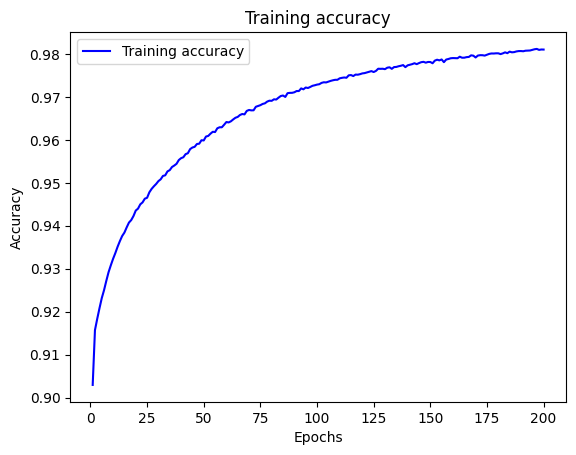

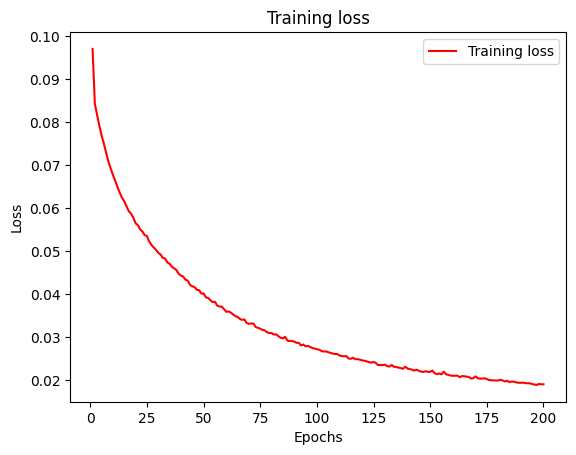

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 2
net = UNet()

if torch.cuda.device_count() > 1:
    print ("multi GPUs")
    net = nn.DataParallel(net,device_ids = [0, 1])

train_data_path = "../../dataset_gopro/train"
train_dataset = Gopro_Loader(data_path=train_data_path, augmentation=False)
train_loader = torch.utils.data.DataLoader(
                                        dataset=train_dataset,
                                        batch_size=batch_size, 
                                        shuffle=True)
print (f'gopro dataset train size: {len(train_dataset)}')

eval_data_path = "../../dataset_gopro/eval"
eval_dataset = Gopro_Loader(data_path=eval_data_path, augmentation=False)
eval_loader = torch.utils.data.DataLoader(
                                        dataset=eval_dataset,
                                        batch_size=1, 
                                        shuffle=True)
print (f'gopro dataset test size: {len(eval_loader)}')

acc_record, loss_record, folder_path = train_net(
    net, train_loader, eval_loader, num_epochs=200, learning_rate=0.001, device=device)

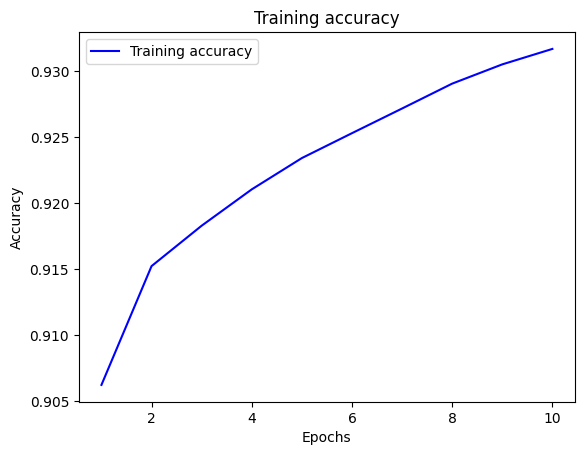

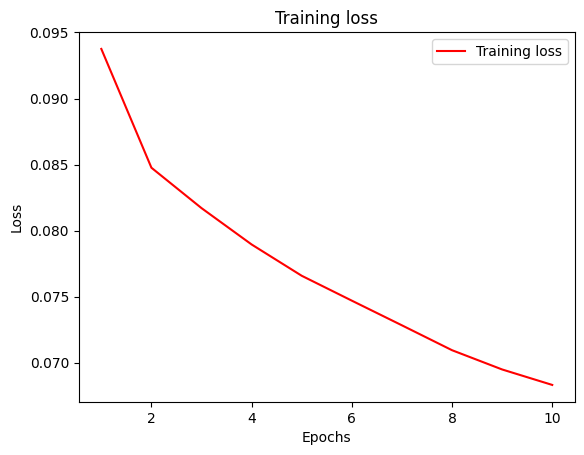

In [12]:
metrics={"accuracy": acc_record, "loss": loss_record}
plot_metrics(metrics, folder_path)

['../../dataset_gopro/test/blur\\GOPR0871_11_01_000181.png',
 '../../dataset_gopro/test/blur\\GOPR0871_11_01_000182.png',
 '../../dataset_gopro/test/blur\\GOPR0871_11_01_000183.png',
 '../../dataset_gopro/test/blur\\GOPR0871_11_01_000184.png',
 '../../dataset_gopro/test/blur\\GOPR0871_11_01_000185.png',
 '../../dataset_gopro/test/blur\\GOPR0871_11_01_000186.png',
 '../../dataset_gopro/test/blur\\GOPR0871_11_01_000187.png',
 '../../dataset_gopro/test/blur\\GOPR0871_11_01_000188.png',
 '../../dataset_gopro/test/blur\\GOPR0871_11_01_000189.png',
 '../../dataset_gopro/test/blur\\GOPR0871_11_01_000190.png',
 '../../dataset_gopro/test/blur\\GOPR0871_11_01_000191.png',
 '../../dataset_gopro/test/blur\\GOPR0871_11_01_000192.png',
 '../../dataset_gopro/test/blur\\GOPR0871_11_01_000193.png',
 '../../dataset_gopro/test/blur\\GOPR0871_11_01_000194.png',
 '../../dataset_gopro/test/blur\\GOPR0871_11_01_000195.png',
 '../../dataset_gopro/test/blur\\GOPR0871_11_01_000196.png',
 '../../dataset_gopro/te

In [20]:
class Gopro_Loader(Dataset):
    def __init__(self, data_path, augmentation=False):
        self.data_path = data_path
        self.augmentation = augmentation
        self.imgs = glob.glob(os.path.join(data_path, 'blur/*.png'))

    def __getitem__(self, idx):
        # 讀取影像
        img_path = self.imgs[idx]
        label_path = img_path.replace("blur", "sharp")
        
        # 讀取標籤
        img = Image.open(img_path)
        label = Image.open(label_path)
        
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
        if self.augmentation:
            # 固定隨機參數
            p1 = random.randint(0,1)
            p2 = random.randint(0,1)

            px = random.uniform(0,1)
            py = random.uniform(0,1)
            crop_size = (368, 640)
            
            def random_crop(img):
                x = (img.size[0]-crop_size[0])*px
                y = (img.size[1]-crop_size[1])*py
                return img.crop((x, y, x+crop_size[0], y+crop_size[1]))

            transform = transforms.Compose([
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomVerticalFlip(0.5),
                transforms.RandomCrop(size=(crop_size)),
                transforms.ToTensor(),
            ])

        img = transform(img)
        label = transform(label)
        return img, label

    def __len__(self):
        return len(self.imgs)

In [24]:

test_dataset = Gopro_Loader(data_path="../../dataset_gopro/test")
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

save_path = './run11/compare'
net = UNet()
# 选择设备，有cuda用cuda，没有就用cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.device_count() > 1:
    print ("multi GPUs")
    net = nn.DataParallel(net,device_ids = [0, 1])
net.to(device=device)

model_path = f'./run11/epoch_199_model.pth'
net.load_state_dict(torch.load(model_path, map_location=device))
count = 0
for x, y in test_loader:
    x, y = x.to(device=device), y.to(device=device)
    with torch.no_grad():
        pred = net(x)
        save_image(pred, f'{save_path}/{count}.png')
        count+=1

multi GPUs


In [9]:
photo_images = os.listdir("../../dataset_gopro/train/blur")
photo_images = [os.path.join("../../dataset_gopro/train/blur", file) for file in photo_images if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]
photo_images

['../../dataset_gopro/train/blur\\GOPR0372_07_00_000047.png',
 '../../dataset_gopro/train/blur\\GOPR0372_07_00_000048.png',
 '../../dataset_gopro/train/blur\\GOPR0372_07_00_000049.png',
 '../../dataset_gopro/train/blur\\GOPR0372_07_00_000050.png',
 '../../dataset_gopro/train/blur\\GOPR0372_07_00_000051.png',
 '../../dataset_gopro/train/blur\\GOPR0372_07_00_000052.png',
 '../../dataset_gopro/train/blur\\GOPR0372_07_00_000053.png',
 '../../dataset_gopro/train/blur\\GOPR0372_07_00_000054.png',
 '../../dataset_gopro/train/blur\\GOPR0372_07_00_000055.png',
 '../../dataset_gopro/train/blur\\GOPR0372_07_00_000056.png',
 '../../dataset_gopro/train/blur\\GOPR0372_07_00_000057.png',
 '../../dataset_gopro/train/blur\\GOPR0372_07_00_000058.png',
 '../../dataset_gopro/train/blur\\GOPR0372_07_00_000059.png',
 '../../dataset_gopro/train/blur\\GOPR0372_07_00_000060.png',
 '../../dataset_gopro/train/blur\\GOPR0372_07_00_000061.png',
 '../../dataset_gopro/train/blur\\GOPR0372_07_00_000062.png',
 '../../

In [10]:
save_path = './run18/compare'
net = UNet()
# 选择设备，有cuda用cuda，没有就用cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.device_count() > 1:
    print ("multi GPUs")
    net = nn.DataParallel(net,device_ids = [0, 1])
net.to(device=device)

model_path = f'./run18/epoch_199_model.pth'
net.load_state_dict(torch.load(model_path, map_location=device))

transform = transforms.Compose([
    transforms.ToTensor(),
])
for img_path in photo_images:
    print (img_path)
    img = Image.open(img_path)
    img = transform(img).unsqueeze(0)
    img.to(device=device)
    pred = net(img)
    basename = os.path.basename(img_path)
    save_image(pred, f'{save_path}/{basename}.png')

multi GPUs
../../dataset_gopro/train/blur\GOPR0372_07_00_000047.png
../../dataset_gopro/train/blur\GOPR0372_07_00_000048.png
../../dataset_gopro/train/blur\GOPR0372_07_00_000049.png
../../dataset_gopro/train/blur\GOPR0372_07_00_000050.png
../../dataset_gopro/train/blur\GOPR0372_07_00_000051.png
../../dataset_gopro/train/blur\GOPR0372_07_00_000052.png
../../dataset_gopro/train/blur\GOPR0372_07_00_000053.png
../../dataset_gopro/train/blur\GOPR0372_07_00_000054.png
../../dataset_gopro/train/blur\GOPR0372_07_00_000055.png
../../dataset_gopro/train/blur\GOPR0372_07_00_000056.png
../../dataset_gopro/train/blur\GOPR0372_07_00_000057.png
../../dataset_gopro/train/blur\GOPR0372_07_00_000058.png
../../dataset_gopro/train/blur\GOPR0372_07_00_000059.png
../../dataset_gopro/train/blur\GOPR0372_07_00_000060.png
../../dataset_gopro/train/blur\GOPR0372_07_00_000061.png
../../dataset_gopro/train/blur\GOPR0372_07_00_000062.png
../../dataset_gopro/train/blur\GOPR0372_07_00_000063.png
../../dataset_gopro/

KeyboardInterrupt: 

In [15]:
img_path

'../../dataset_gopro/test/blur\\GOPR0871_11_01_000181.png'